<a href="https://colab.research.google.com/github/EricSantosOliveira/DIO_Machine_Learning/blob/main/DIO_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- 1. IMPORTAR BIBLIOTECAS ---
import tensorflow as tf
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
from google.colab import files

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model # Importa load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image # Para carregar imagens individuais


In [2]:
# --- 2. UPLOAD DO ARQUIVO ZIP E EXTRAÇÃO ---
print("Por favor, faça o upload do arquivo 'meus_animais.zip'")
uploaded = files.upload()

zip_path = 'meus_animais.zip'
extract_dir = 'meus_animais_dataset' # Diretório para onde o conteúdo será extraído

# Verifica se o arquivo zip foi realmente enviado
if zip_path not in uploaded:
    print(f"Erro: O arquivo '{zip_path}' não foi encontrado entre os uploads.")
else:
    # Extração
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset extraído para '{extract_dir}'")

    # Exemplo: listar o conteúdo para verificar a estrutura
    print("\nConteúdo da pasta extraída:")
    for root, dirs, files in os.walk(extract_dir):
        level = root.replace(extract_dir, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

Por favor, faça o upload do arquivo 'meus_animais.zip'


Saving meus_animais.zip to meus_animais.zip
Dataset extraído para 'meus_animais_dataset'

Conteúdo da pasta extraída:
meus_animais_dataset/
    Gato/
        gato-vira-lata.jpg
    Cachorro/
        istockphoto-803485968-612x612.jpg


In [3]:
# --- 3. CRIAR DATASET DE IMAGENS ---
# Certifique-se de que a estrutura dentro do ZIP é: meus_animais_dataset/classe1/imagem.jpg, meus_animais_dataset/classe2/imagem.jpg
# Ex: meus_animais_dataset/gatos/gato1.jpg e meus_animais_dataset/cachorros/cachorro1.jpg

IMG_HEIGHT = 160
IMG_WIDTH = 160
BATCH_SIZE = 32

dataset = tf.keras.utils.image_dataset_from_directory(
    extract_dir, # Usa o diretório extraído
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle=True
)

Found 2 files belonging to 2 classes.


In [4]:
# --- 4. DIVIDIR EM TREINO E VALIDAÇÃO ---
# Calcular o tamanho de cada dataset
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
val_size = int(0.2 * dataset_size) # 20% para validação
train_size = dataset_size - val_size # Restante para treino

val_dataset = dataset.take(val_size)
train_dataset = dataset.skip(val_size)

print(f"\nNúmero de batches para treino: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Número de batches para validação: {tf.data.experimental.cardinality(val_dataset).numpy()}")


Número de batches para treino: 1
Número de batches para validação: 0


In [5]:
# --- 5. MELHORAR DESEMPENHO DO DATASET ---
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# --- 6. CONSTRUÇÃO DO MODELO COM TRANSFER LEARNING ---
# Modelo base (MobileNetV2)
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False # Congela as camadas do modelo base

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# --- 6. CONSTRUÇÃO DO MODELO COM TRANSFER LEARNING ---
# Modelo base (MobileNetV2)
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False # Congela as camadas do modelo base

# Camadas finais
x = base_model.output
x = GlobalAveragePooling2D()(x) # Converte os feature maps em um vetor
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) # 1 neurônio com sigmoid para classificação binária

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), # Taxa de aprendizado menor para fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# --- 7. TREINAMENTO DO MODELO ---
EPOCHS = 5
print(f"\nIniciando o treinamento por {EPOCHS} épocas...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset, # **Verifique se 'val_dataset' está realmente sendo passado aqui**
    epochs=EPOCHS
)
print("Treinamento concluído.")


Iniciando o treinamento por 5 épocas...
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.2454
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 0.1971
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.1600
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.1310
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 0.1083
Treinamento concluído.


In [16]:
import os

extract_dir = 'meus_animais_dataset' # Certifique-se que este é o nome da pasta para onde você extraiu

if not os.path.exists(extract_dir):
    print(f"ERRO: O diretório '{extract_dir}' não existe. Verifique o caminho da extração.")
else:
    print(f"Conteúdo de '{extract_dir}':")
    for root, dirs, files in os.walk(extract_dir):
        level = root.replace(extract_dir, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

Conteúdo de 'meus_animais_dataset':
meus_animais_dataset/
    Gato/
        gato-vira-lata.jpg
    Cachorro/
        istockphoto-803485968-612x612.jpg



Iniciando o treinamento por 5 épocas...
AVISO: Dataset de validação vazio. Treinando sem dados de validação.
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 0.0903
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0761
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0648
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0559
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 1.0000 - loss: 0.0487
Treinamento concluído.

Chaves disponíveis no histórico de treinamento:
dict_keys(['accuracy', 'loss'])


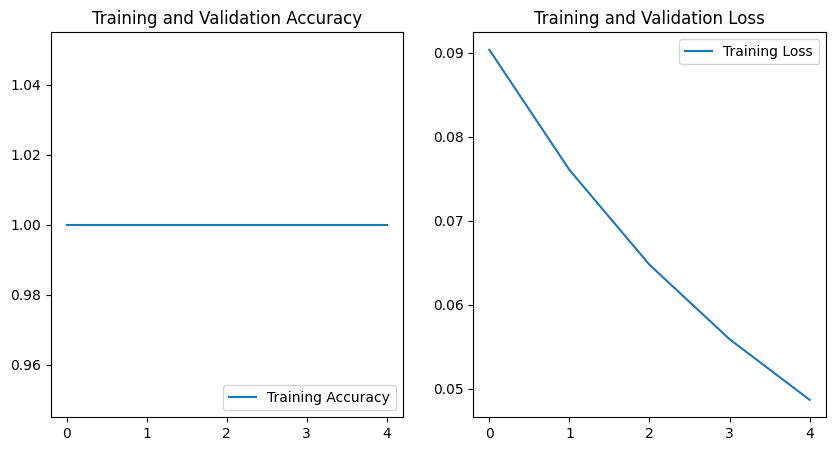

In [17]:
# ... (seu código de modelo e compilação) ...

# Treinamento
EPOCHS = 5
print(f"\nIniciando o treinamento por {EPOCHS} épocas...")

# Adicione esta verificação antes do fit para garantir que val_dataset não está vazio
if tf.data.experimental.cardinality(val_dataset).numpy() > 0:
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS
    )
else:
    print("AVISO: Dataset de validação vazio. Treinando sem dados de validação.")
    history = model.fit(
        train_dataset,
        epochs=EPOCHS
    )

print("Treinamento concluído.")

# --- 8. AVALIAÇÃO E PLOT DA HISTÓRIA DO TREINAMENTO ---

print("\nChaves disponíveis no histórico de treinamento:")
print(history.history.keys())

acc = history.history['accuracy']
loss = history.history['loss']

# Condicionalmente plotar a validação se as chaves existirem
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
if 'val_accuracy' in history.history:
    val_acc = history.history['val_accuracy']
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
if 'val_loss' in history.history:
    val_loss = history.history['val_loss']
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# --- 9. SALVAR E BAIXAR O MODELO ---
model_save_path = 'meu_modelo.h5'
model.save(model_save_path)
print(f"\nModelo salvo em '{model_save_path}'")

# Permite que você baixe o arquivo para sua máquina local
from google.colab import files
files.download(model_save_path)
print("Download do modelo concluído.")


Modelo salvo em 'meu_modelo.h5'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download do modelo concluído.


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model # Importa para carregar o modelo
from google.colab import files # Para upload de imagens

# --- 1. Carregar o Modelo Treinado ---
# O caminho para o modelo que você salvou na etapa anterior
model_path = 'meu_modelo.h5'
try:
    modelo_carregado = load_model(model_path)
    print(f"Modelo carregado com sucesso de '{model_path}'")
except Exception as e:
    print(f"Erro ao carregar o modelo. Certifique-se de que '{model_path}' foi salvo corretamente. Erro: {e}")
    # Se o modelo não carregar, não podemos continuar com as previsões.
    # Verifique se a célula anterior de salvamento rodou sem erros.
    exit() # Interrompe a execução se o modelo não puder ser carregado

# Definir as dimensões da imagem (deve ser a mesma usada no treinamento do modelo)
IMG_HEIGHT = 160
IMG_WIDTH = 160

# Definir os nomes das classes na ordem correta
# IMPORTANTE: Essa ordem é alfabética com base nos nomes das pastas que você usou no dataset.
# Por exemplo, se você tinha pastas 'cachorros' e 'gatos', 'cachorros' (0) vem antes de 'gatos' (1).
# Ajuste esta lista se a ordem for diferente para o seu dataset!
class_names = ['Gato', 'Cachorro'] # Exemplo: 'Gato' para output próximo de 0, 'Cachorro' para output próximo de 1

# --- 2. Fazer Upload das Novas Imagens para Teste ---
print("\nPor favor, faça o upload das imagens que deseja testar (ex: meu_gato.jpg, meu_cachorro.png):")
uploaded_test_images = files.upload()

# Cria um diretório temporário para salvar as imagens de teste que você carregou
test_images_dir = 'temp_test_images_predictions'
os.makedirs(test_images_dir, exist_ok=True)

for filename, content in uploaded_test_images.items():
    with open(os.path.join(test_images_dir, filename), 'wb') as f:
        f.write(content)
    print(f"Imagem '{filename}' salva para teste.")

# --- 3. Processar e Prever Novas Imagens ---
print("\nRealizando previsões nas novas imagens:")
for arquivo in os.listdir(test_images_dir):
    caminho_imagem = os.path.join(test_images_dir, arquivo)

    # Ignorar arquivos que não são imagens ou são diretórios (ex: .ipynb_checkpoints)
    if not (caminho_imagem.lower().endswith(('.png', '.jpg', '.jpeg')) and os.path.isfile(caminho_imagem)):
        continue

    print(f"\nProcessando imagem: {arquivo}")

    try:
        # Carregar a imagem e redimensioná-la para o tamanho que o modelo espera
        img = image.load_img(caminho_imagem, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = image.img_to_array(img) # Converte a imagem para um array NumPy
        # Adiciona uma dimensão extra para o batch (o modelo espera um batch de imagens)
        img_array = np.expand_dims(img_array, axis=0) # Agora tem o formato (1, H, W, C)
        img_array = img_array / 255.0 # Normaliza os valores dos pixels para o intervalo [0, 1]

        # Fazer a previsão
        # O modelo_carregado.predict retorna um array de previsões para o batch.
        # Como passamos apenas uma imagem, pegamos o primeiro (e único) elemento [0].
        # A saída da camada sigmoid é um valor entre 0 e 1, então pegamos o primeiro elemento [0].
        prediction_score = modelo_carregado.predict(img_array)[0][0]

        # Interpretar a previsão
        # Se o score for maior que 0.5, classificamos como a classe 1 (Cachorro no meu exemplo).
        # Caso contrário, classificamos como a classe 0 (Gato).
        predicted_class_index = 1 if prediction_score > 0.5 else 0
        predicted_class_name = class_names[predicted_class_index]

        # Calcular a confiança na previsão
        # Se previu Cachorro (classe 1), a confiança é o próprio score.
        # Se previu Gato (classe 0), a confiança é 1 - o score.
        confidence = prediction_score if predicted_class_index == 1 else (1 - prediction_score)

        # Exibir a imagem com a previsão e a confiança
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off') # Remove os eixos
        plt.title(f"Arquivo: {arquivo}\nPrevisão: {predicted_class_name} (Confiança: {confidence*100:.2f}%)")
        plt.show()

    except Exception as e:
        print(f"Erro ao processar a imagem '{arquivo}': {e}")

# Opcional: Limpar o diretório temporário após as previsões
# import shutil
# shutil.rmtree(test_images_dir)
# print(f"\nDiretório temporário '{test_images_dir}' removido.")

Modelo carregado com sucesso de 'meu_modelo.h5'

Por favor, faça o upload das imagens que deseja testar (ex: meu_gato.jpg, meu_cachorro.png):


Saving Meus_animais_Teste.zip to Meus_animais_Teste.zip
Imagem 'Meus_animais_Teste.zip' salva para teste.

Realizando previsões nas novas imagens:
